# Trexquant Interview Project (The Hangman Game)

* Copyright Trexquant Investment LP. All Rights Reserved. 
* Redistribution of this question without written consent from Trexquant is prohibited

## Instruction:
For this coding test, your mission is to write an algorithm that plays the game of Hangman through our API server. 

When a user plays Hangman, the server first selects a secret word at random from a list. The server then returns a row of underscores (space separated)—one for each letter in the secret word—and asks the user to guess a letter. If the user guesses a letter that is in the word, the word is redisplayed with all instances of that letter shown in the correct positions, along with any letters correctly guessed on previous turns. If the letter does not appear in the word, the user is charged with an incorrect guess. The user keeps guessing letters until either (1) the user has correctly guessed all the letters in the word
or (2) the user has made six incorrect guesses.

You are required to write a "guess" function that takes current word (with underscores) as input and returns a guess letter. You will use the API codes below to play 1,000 Hangman games. You have the opportunity to practice before you want to start recording your game results.

Your algorithm is permitted to use a training set of approximately 250,000 dictionary words. Your algorithm will be tested on an entirely disjoint set of 250,000 dictionary words. Please note that this means the words that you will ultimately be tested on do NOT appear in the dictionary that you are given. You are not permitted to use any dictionary other than the training dictionary we provided. This requirement will be strictly enforced by code review.

You are provided with a basic, working algorithm. This algorithm will match the provided masked string (e.g. a _ _ l e) to all possible words in the dictionary, tabulate the frequency of letters appearing in these possible words, and then guess the letter with the highest frequency of appearence that has not already been guessed. If there are no remaining words that match then it will default back to the character frequency distribution of the entire dictionary.

This benchmark strategy is successful approximately 18% of the time. Your task is to design an algorithm that significantly outperforms this benchmark.

In [3]:
import json
import requests
import random
import string
import secrets
import time
import re
import collections

try:
    from urllib.parse import parse_qs, urlencode, urlparse
except ImportError:
    from urlparse import parse_qs, urlparse
    from urllib import urlencode

from requests.packages.urllib3.exceptions import InsecureRequestWarning


requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

C:\Users\vssd9\AppData\Local\Temp\ipykernel_42944\3987458867.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


As you can see, rarely a word is having more than 0.70 fraction of vowel, so I am removing any guess if it is a vowel and 
if vowel fraction is already 0.66.


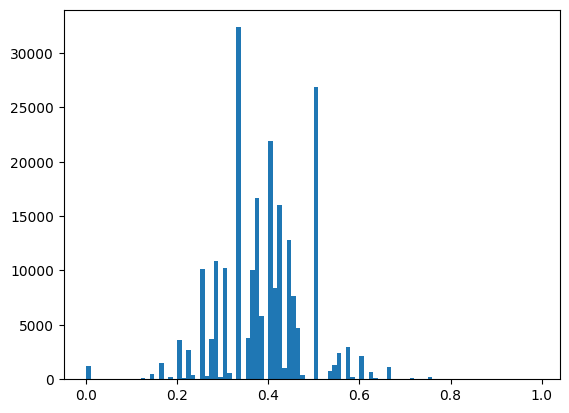

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
vowels = ['a', 'e', 'i', 'o', 'u']

# for ratio of vowels to length of word
def vowel_ratio(clean_word):
    count = 0
    for i in clean_word:
        if i in vowels:
            count = count+1.0
    return count/len(clean_word)

v = open("words_250000_train.txt", "r")
dv = []
for x in v:
    dv.append(x)
for i in range(len(dv)):
    dv[i] = dv[i].replace("\n", "")
l=[]
for words in dv:
    l.append(vowel_ratio(words))
l = pd.Series(l)
l.describe()

bins = np.arange(0.0, 1.0, 0.01)
plt.hist(x = l, bins = bins)
print('As you can see, rarely a word is having more than 0.70 fraction of vowel, so I am removing any guess if it is a vowel and '), 
print( 'if vowel fraction is already 0.66.' )

Maximum length of a word in the training dictionary is 29
As you you can see from the plot below, almost all words are of lenght less than 20. For training the my code I will use words with lenght < 22.


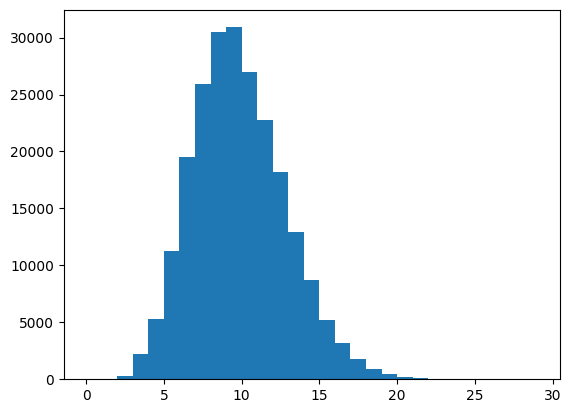

In [5]:
ved=[]
for a in dv:
    ved.append(len(a))
ved = pd.Series(ved)
ved.describe()
bin= np.arange(0, 30, 1)
plt.hist(x=ved,bins=bin)

maximum_length = 0
for words in dv:
    if(len(words)>maximum_length):
        maximum_length = len(words)
print('Maximum length of a word in the training dictionary is', maximum_length)
print('As you you can see from the plot below, almost all words are of lenght less than 20. For training the my code I will use words with lenght < 22.')

In [6]:
#This snipet will break down every word to have bigger data set to train
# e.g. "greater" word will be divided into substrings of lenght 3, 4, 5, and 6 it will be for every word
# Breaking downing words like this gives accurate and fast guesses for the first half part of the word

broken_down_word_dictionary = {i:[] for i in range(3, 30)}
count = 3
while count<=maximum_length:
    for words in dv:
        if(len(words)>=count):
            for i in range(len(words)-count+1):
                #if words[i:i+count-1] not in n_word_dictionary[count]:
                broken_down_word_dictionary[count].append(words[i:i+count]) 
             
    count = count+1

# function to find number of times a letter come in whole dictionary, keeping count of letter 1 if it comes in a word else 0
def func(new_dictionary):
    dictionary_l = collections.Counter()
    for words in new_dictionary:
        letter_count = collections.Counter(words)
        for i in letter_count:
            letter_count[i] = 1
            dictionary_l = dictionary_l + letter_count
    return dictionary_l

# function to generate a list of words which are substring in the original dictionary and of same length as clean word
def func2(n_word_dictionary, clean_word):
    new_dictionary = []
    l = len(clean_word)
    for dict_word in broken_down_word_dictionary[l]:
        if re.match(clean_word,dict_word):
            new_dictionary.append(dict_word)
    return new_dictionary




class HangmanAPI(object):
    def __init__(self, access_token=None, session=None, timeout=None):
        self.hangman_url = self.determine_hangman_url()
        self.access_token = access_token
        self.session = session or requests.Session()
        self.timeout = timeout
        self.guessed_letters = []
        
        full_dictionary_location = "words_250000_train.txt"
        self.full_dictionary = self.build_dictionary(full_dictionary_location)        
        self.full_dictionary_common_letter_sorted = collections.Counter("".join(self.full_dictionary)).most_common()
        
        self.current_dictionary = []
        
    @staticmethod
    def determine_hangman_url():
        links = ['https://trexsim.com', 'https://sg.trexsim.com']

        data = {link: 0 for link in links}

        for link in links:

            requests.get(link)

            for i in range(10):
                s = time.time()
                requests.get(link)
                data[link] = time.time() - s

        link = sorted(data.items(), key=lambda x: x[1])[0][0]
        link += '/trexsim/hangman'
        return link

    def guess(self, word): # word input example: "_ p p _ e "
        ###############################################
        # Replace with your own "guess" function here #
        ###############################################

          # clean the word so that we strip away the space characters
        # replace "_" with "." as "." indicates any character in regular expressions
        clean_word = word[::2].replace("_",".")
        
        # find length of passed word
        len_word = len(clean_word)
        
        # grab current dictionary of possible words from self object, initialize new possible words dictionary to empty
        current_dictionary = self.current_dictionary
        new_dictionary = []
        
        # find all the letters that have been correctly guessed
        correct_letters = [] 
        for i in clean_word:
            if i !='.':
                correct_letters.append(i)
        
        # find all the letters that have been incorrectly guessed
        incorrect_letters = []
        for i in self.guessed_letters:
            if i not in correct_letters:
                incorrect_letters.append(i)
       
                
        # iterate through all of the words in the old plausible dictionary
        for dict_word in current_dictionary:
            # continue if the word is not of the appropriate length
            if len(dict_word) != len_word:
                continue
                
            # if dictionary word is a possible match then add it to the current dictionary, taking care that we remove letters that have not been guessed correctly
            if re.match(clean_word,dict_word):
                for i in self.guessed_letters:
                    if i not in correct_letters :
                        continue
                new_dictionary.append(dict_word)
        
      

  # overwrite old possible words dictionary with updated version
        self.current_dictionary = new_dictionary
        guess_letter = '!'

        
        # count occurrence of all characters in possible word matches
        full_dict_string = "".join(new_dictionary)
        
        c = collections.Counter(full_dict_string)
        by_ved= collections.Counter(full_dict_string)
        sorted_letter_count_full = by_ved.most_common()             
        guess_letter = '!'



  # Following part will use most frequently occuring letters to guess the 50% of the word. using the broken_broken_down_dictionary
  
        if len(correct_letters)/len(clean_word) <0.5:
            by_ved = func(new_dictionary)        
            sorted_letter_count = by_ved.most_common()                          
            guess_letter = '!'
            for letter,instance_count in sorted_letter_count:
                if letter not in self.guessed_letters:
                    if letter in vowels and vowel_ratio(clean_word)>0.66:
                        self.guessed_letters.append(letter)
                        continue
                    guess_letter = letter
                    break
            if guess_letter == '!':
                new_dictionary = func2(broken_down_word_dictionary, clean_word)
                by_ved = func(new_dictionary)
                sorted_letter_count = by_ved.most_common()
                for letter,instance_count in sorted_letter_count:
                    if letter not in self.guessed_letters:
                        if letter in vowels and vowel_ratio(clean_word)>0.66:
                            self.guessed_letters.append(letter)
                            continue
                        guess_letter = letter
                        break

            if guess_letter == '!':
                x = int(len(clean_word)/2)
                if x>=3:
                    by_ved = collections.Counter()
                    for i in range(len(clean_word)-x+1):
                        s = clean_word[i:i+x]
                        new_dictionary = func2(broken_down_word_dictionary, s)
                        letter_count = func(new_dictionary)
                        by_ved = by_ved+letter_count
                    sorted_letter_count = by_ved.most_common()
                    for letter, instance_count in sorted_letter_count:
                        if letter not in self.guessed_letters:
                            guess_letter = letter
                            break
                        
                        
            if guess_letter == '!':
                sorted_letter_count = self.full_dictionary_common_letter_sorted
                for letter,instance_count in sorted_letter_count:
                    if letter not in self.guessed_letters:
                        if letter in vowels and vowel_ratio(clean_word)>0.66:
                            self.guessed_letters.append(letter)
                            continue
                        guess_letter = letter
                        break
            return guess_letter
       

    

  # Following part will look for specific occurunce of group of letters in the training dictionary
  # It will try to match those group of letters with the word which is already 50% guessed.

        self.current_dictionary = new_dictionary
        guess_letter = '!'
        
        # count occurrence of all characters in possible word matches
        full_dict_string = "".join(new_dictionary)
        
        c = collections.Counter(full_dict_string)
        sorted_letter_count_full = c.most_common()     
        
        # This part divides the entire words of dictionary into substrings of different length, and stores it.
        # This is similar to what I did with broken_down_dictionary.
        group_of_letters = []
        groups_num = []
        for k in range (3,20):
            groups_num = []
            for i in range(len(self.full_dictionary)):
                j=0
                while j+k <= len(self.full_dictionary[i]):
                    for a in incorrect_letters:
                        if a in self.full_dictionary[i][j:j+k]:
                            break
                        groups_num.append(self.full_dictionary[i][j:j+k])
                    j=j+1
            group_of_letters.append(groups_num)
            


        clean_word = word[::2].replace('_','.')
        
        
        # this snippet collects all possible groups containing an unguessed letter.
        len_v = len(clean_word)
        group_collection = []
       

        #
        for i in range(int(len(clean_word)*.55)+1):
                for j in range(i,len(clean_word)):
                    if '.' in clean_word[i:j+1]:
                        group_collection.append(clean_word[i:j+1])

        
        # Now, I have collection of group of letters
        # I will have to calculate the frequency of letters occuring in words that matches with specific group of letters.
        # Normalising the frequency and guessing a letter which has highest score. The score is sum of the normalised probabilities of a letter.
        # converts the list to one joint string
        calc = []
        collect = []
        group_collection_str = ['' for _ in range(len(group_collection))]
        for i in range (len(group_collection)):
            generator_expr = (str(element) for element in group_collection[i])
            separator = ''
            group_collection_str[i] = separator.join(generator_expr)

        # collects the matchin group    
        for group_obtained in group_collection_str:
            for group_dict in group_of_letters[len(group_obtained) - 3]:
                if re.match(group_obtained, group_dict):
                    collect.append(group_dict)
            calc.append(collect)
            collect = []

        # List with 1st letter with highes probability
        c=[0 for _ in range(len(calc))]
        sorted_letter_count=[0 for _ in range(len(calc))]
        for i in range (len(calc)):
            full_dict_string = ''.join(calc[i])  
            c[i] = collections.Counter(full_dict_string)
            sorted_letter_count[i] = (c[i].most_common())
            
        # Sum of total number of letters
        total_letters = [0 for _ in range(len(sorted_letter_count))]
        for i in range(len(sorted_letter_count)):
            total_letters[i] = sum(tup[1] for tup in sorted_letter_count[i])

        # Normalise the frequency and calculate probability
        sorted_letter_prob = []
        letter_prob = []
        for i in range(len(sorted_letter_count)):
            for j in range(len(sorted_letter_count[i])):
                letter_prob.append(sorted_letter_count[i][j][1]/total_letters[i])
            sorted_letter_prob.append(letter_prob)
            letter_prob = []
                
        normalised_letter_prob = []
        k = []
        for i in range(len(sorted_letter_count)):
            for j in range(len(sorted_letter_count[i])):
                k.append([sorted_letter_count[i][j][0], sorted_letter_prob[i][j]])
            normalised_letter_prob.append(k)
            k = []

        # Gives sum of normalised probabilities for each group of letters     
        normalised_prob_sum = [0 for _ in range(26)]
        for i in range(len(normalised_letter_prob)):
            for j in range(len(normalised_letter_prob[i])):
                normalised_prob_sum[ord(normalised_letter_prob[i][j][0]) - 97]+= normalised_letter_prob[i][j][1]

        guess_list = []
        for i in range(26):
            guess_list.append([chr(i+97), normalised_prob_sum[i]])
        
        sorted_guess_list = sorted(guess_list, key=lambda x: x[1], reverse = True)
        
                    
        # returns the letter if it is not already guessed
        for i in sorted_guess_list:
            if i[0] not in self.guessed_letters:
                guess_letter = i[0]
                break

        return guess_letter        


##########################################################
    # You'll likely not need to modify any of the code below #
    ##########################################################
    
    def build_dictionary(self, dictionary_file_location):
        text_file = open(dictionary_file_location,"r")
        full_dictionary = text_file.read().splitlines()
        text_file.close()
        return full_dictionary
                
    def start_game(self, practice=True, verbose=True):
        # reset guessed letters to empty set and current plausible dictionary to the full dictionary
        self.guessed_letters = []
        self.current_dictionary = self.full_dictionary
                         
        response = self.request("/new_game", {"practice":practice})
        if response.get('status')=="approved":
            game_id = response.get('game_id')
            word = response.get('word')
            tries_remains = response.get('tries_remains')
            if verbose:
                print("Successfully start a new game! Game ID: {0}. # of tries remaining: {1}. Word: {2}.".format(game_id, tries_remains, word))
            while tries_remains>0:
                # get guessed letter from user code
                guess_letter = self.guess(word)
                    
                # append guessed letter to guessed letters field in hangman object
                self.guessed_letters.append(guess_letter)
                if verbose:
                    print("Guessing letter: {0}".format(guess_letter))
                    
                try:    
                    res = self.request("/guess_letter", {"request":"guess_letter", "game_id":game_id, "letter":guess_letter})
                except HangmanAPIError:
                    print('HangmanAPIError exception caught on request.')
                    continue
                except Exception as e:
                    print('Other exception caught on request.')
                    raise e
               
                if verbose:
                    print("Sever response: {0}".format(res))
                status = res.get('status')
                tries_remains = res.get('tries_remains')
                if status=="success":
                    if verbose:
                        print("Successfully finished game: {0}".format(game_id))
                    return True
                elif status=="failed":
                    reason = res.get('reason', '# of tries exceeded!')
                    if verbose:
                        print("Failed game: {0}. Because of: {1}".format(game_id, reason))
                    return False
                elif status=="ongoing":
                    word = res.get('word')
        else:
            if verbose:
                print("Failed to start a new game")
        return status=="success"
        
    def my_status(self):
        return self.request("/my_status", {})
    
    def request(
            self, path, args=None, post_args=None, method=None):
        if args is None:
            args = dict()
        if post_args is not None:
            method = "POST"

        # Add `access_token` to post_args or args if it has not already been
        # included.
        if self.access_token:
            # If post_args exists, we assume that args either does not exists
            # or it does not need `access_token`.
            if post_args and "access_token" not in post_args:
                post_args["access_token"] = self.access_token
            elif "access_token" not in args:
                args["access_token"] = self.access_token

        time.sleep(0.2)

        num_retry, time_sleep = 50, 2
        for it in range(num_retry):
            try:
                response = self.session.request(
                    method or "GET",
                    self.hangman_url + path,
                    timeout=self.timeout,
                    params=args,
                    data=post_args,
                    verify=False
                )
                break
            except requests.HTTPError as e:
                response = json.loads(e.read())
                raise HangmanAPIError(response)
            except requests.exceptions.SSLError as e:
                if it + 1 == num_retry:
                    raise
                time.sleep(time_sleep)

        headers = response.headers
        if 'json' in headers['content-type']:
            result = response.json()
        elif "access_token" in parse_qs(response.text):
            query_str = parse_qs(response.text)
            if "access_token" in query_str:
                result = {"access_token": query_str["access_token"][0]}
                if "expires" in query_str:
                    result["expires"] = query_str["expires"][0]
            else:
                raise HangmanAPIError(response.json())
        else:
            raise HangmanAPIError('Maintype was not text, or querystring')

        if result and isinstance(result, dict) and result.get("error"):
            raise HangmanAPIError(result)
        return result
    
class HangmanAPIError(Exception):
    def __init__(self, result):
        self.result = result
        self.code = None
        try:
            self.type = result["error_code"]
        except (KeyError, TypeError):
            self.type = ""

        try:
            self.message = result["error_description"]
        except (KeyError, TypeError):
            try:
                self.message = result["error"]["message"]
                self.code = result["error"].get("code")
                if not self.type:
                    self.type = result["error"].get("type", "")
            except (KeyError, TypeError):
                try:
                    self.message = result["error_msg"]
                except (KeyError, TypeError):
                    self.message = result

        Exception.__init__(self, self.message)

# API Usage Examples

## To start a new game:
1. Make sure you have implemented your own "guess" method.
2. Use the access_token that we sent you to create your HangmanAPI object. 
3. Start a game by calling "start_game" method.
4. If you wish to test your function without being recorded, set "practice" parameter to 1.
5. Note: You have a rate limit of 20 new games per minute. DO NOT start more than 20 new games within one minute.

In [7]:
api = HangmanAPI(access_token="48d9e77ba573db05a4805a55ca665f", timeout=2000)

In [6]:
api.start_game(practice=1,verbose=True)
[total_practice_runs,total_recorded_runs,total_recorded_successes,total_practice_successes] = api.my_status() # Get my game stats: (# of tries, # of wins)
practice_success_rate = (total_practice_successes) / (total_practice_runs) 
print('run %d practice games out of an allotted 100,000. practice success rate so far = %.3f' % (total_practice_runs, practice_success_rate))

Successfully start a new game! Game ID: 80b241111808. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ .
Guessing letter: i
Sever response: {'game_id': '80b241111808', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ i _ i _ _ _ _ _ _ _ '}
Guessing letter: s
Sever response: {'game_id': '80b241111808', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ i _ i s _ _ _ _ _ _ '}
Guessing letter: t
Sever response: {'game_id': '80b241111808', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ i _ i s _ _ _ t _ _ '}
Guessing letter: r
Sever response: {'game_id': '80b241111808', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ r _ _ i _ i s _ _ _ t _ _ '}
Guessing letter: e
Sever response: {'game_id': '80b241111808', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ r e _ i _ i s _ e _ t _ _ '}
Guessing letter: n
Sever response: {'game_id': '80b241111808', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ n r e _ i n i s _ e n t _ _ '}
Guessin

## Playing practice games:
You can use the command below to play up to 100,000 practice games.

api.start_game(practice=1,verbose=True)
[total_practice_runs,total_recorded_runs,total_recorded_successes,total_practice_successes] = api.my_status() # Get my game stats: (# of tries, # of wins)
practice_success_rate = total_practice_successes / total_practice_runs
print('run %d practice games out of an allotted 100,000. practice success rate so far = %.3f' % (total_practice_runs, practice_success_rate))

## Playing recorded games:
Please finalize your code prior to running the cell below. Once this code executes once successfully your submission will be finalized. Our system will not allow you to rerun any additional games.

Please note that it is expected that after you successfully run this block of code that subsequent runs will result in the error message "Your account has been deactivated".

Once you've run this section of the code your submission is complete. Please send us your source code via email.



In [7]:
for i in range(1000):
    print('Playing ', i, ' th game')
    # Uncomment the following line to execute your final runs. Do not do this until you are satisfied with your submission
    api.start_game(practice=0,verbose=False)
    
    # DO NOT REMOVE as otherwise the server may lock you out for too high frequency of requests
    time.sleep(0.5)

Playing  0  th game
Playing  1  th game
Playing  2  th game
Other exception caught on request.


ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

## To check your game statistics
1. Simply use "my_status" method.
2. Returns your total number of games, and number of wins.

In [8]:
[total_practice_runs,total_recorded_runs,total_recorded_successes,total_practice_successes] = api.my_status() # Get my game stats: (# of tries, # of wins)
success_rate = total_recorded_successes/(total_recorded_runs-17)
print('overall success rate = %.3f' % success_rate)
print('total_recorded_runs= %.3f' %total_recorded_runs)
print('successes=%.3f' %total_recorded_successes)

overall success rate = 0.585
total_recorded_runs= 181.000
successes=96.000
